### Import packages and data

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%matplotlib inline
plt.style.use('bmh')

In [6]:
data = pd.read_csv(R'MoST_scenario\scenario\8-8_30-1-10.csv', sep=';')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 518490 entries, 0 to 518489
Data columns (total 20 columns):
timestep_time    518490 non-null float64
vehicle_angle    272911 non-null float64
vehicle_id       272911 non-null object
vehicle_lane     272911 non-null object
vehicle_pos      272911 non-null float64
vehicle_slope    272911 non-null float64
vehicle_speed    272911 non-null float64
vehicle_type     272911 non-null object
vehicle_x        272911 non-null float64
vehicle_y        272911 non-null float64
vehicle_z        272911 non-null float64
person_angle     245579 non-null float64
person_edge      245579 non-null object
person_id        245579 non-null object
person_pos       245579 non-null float64
person_slope     245579 non-null float64
person_speed     245579 non-null float64
person_x         245579 non-null float64
person_y         245579 non-null float64
person_z         245579 non-null float64
dtypes: float64(15), object(5)
memory usage: 79.1+ MB


### Feature cleaning

##### Check if person/vehicle columns are complementary

In [7]:
features = ['angle', 'id', 'pos', 'slope', 'speed', 'x', 'y', 'z']
for suffix in features:
    bothNAN = data['person_'+suffix][data['vehicle_'+suffix].isna()].isna().values.any()
    bothValues = data['person_'+suffix][data['vehicle_'+suffix].notna()].notna().values.any()
    print(suffix+":", bothNAN, bothValues)

angle: False False
id: False False
pos: False False
slope: False False
speed: False False
x: False False
y: False False
z: False False


##### Merge complementary columns and drop redundant ones

In [8]:
for feature in features:
    data['vehicle_'+feature].fillna(data['person_'+feature], inplace=True)
    data.drop('person_'+feature, axis='columns', inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 518490 entries, 0 to 518489
Data columns (total 12 columns):
timestep_time    518490 non-null float64
vehicle_angle    518490 non-null float64
vehicle_id       518490 non-null object
vehicle_lane     272911 non-null object
vehicle_pos      518490 non-null float64
vehicle_slope    518490 non-null float64
vehicle_speed    518490 non-null float64
vehicle_type     272911 non-null object
vehicle_x        518490 non-null float64
vehicle_y        518490 non-null float64
vehicle_z        518490 non-null float64
person_edge      245579 non-null object
dtypes: float64(8), object(4)
memory usage: 47.5+ MB


##### Check if same applies for "vehicle_lane" / "person_edge"

In [9]:
bothNAN = data['person_edge'][data['vehicle_lane'].isna()].isna().values.any()
bothValues = data['person_edge'][data['vehicle_lane'].notna()].notna().values.any()

bothNAN, bothValues

(False, False)

##### Merge and drop

In [10]:
data['vehicle_lane'].fillna(data['person_edge'], inplace=True)
data.drop('person_edge', axis='columns', inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 518490 entries, 0 to 518489
Data columns (total 11 columns):
timestep_time    518490 non-null float64
vehicle_angle    518490 non-null float64
vehicle_id       518490 non-null object
vehicle_lane     518490 non-null object
vehicle_pos      518490 non-null float64
vehicle_slope    518490 non-null float64
vehicle_speed    518490 non-null float64
vehicle_type     272911 non-null object
vehicle_x        518490 non-null float64
vehicle_y        518490 non-null float64
vehicle_z        518490 non-null float64
dtypes: float64(8), object(3)
memory usage: 43.5+ MB


##### Rename features

In [11]:
data.rename(columns={'timestep_time': "t", 'vehicle_angle': "angle", 'vehicle_id': "ID", 'vehicle_pos': "position",
                     'vehicle_slope': "slope", 'vehicle_speed': "speed", 'vehicle_x': "x", 'vehicle_y': "y",
                     'vehicle_z': "z", 'vehicle_lane': "lane_edge", 'vehicle_type': "v_type", }, inplace=True)

data.head()

,t,angle,ID,lane_edge,position,slope,speed,v_type,x,y,z
0,28800.0,74.69,France:Italy.0,152525#0_0,6.60,3.42,0.00,hw_delivery,66.19,2975.45,385.19
1,28800.0,171.94,Italy:France.0,152272_0,16.60,0.84,0.00,hw_trailer,7025.03,6345.15,280.64
2,28800.0,26.74,pedestrian_1-1-pt_7316_tr,152667#1_1,1.70,-1.06,0.00,fastbicycle,5096.54,2373.27,54.36
3,28800.0,26.74,pedestrian_1-1-pt_7316,152667#1,1.70,-1.06,0.00,NaN,5096.54,2373.27,54.36
4,28810.0,83.23,France:Italy.0,152525#0_0,108.82,3.68,18.47,hw_delivery,165.67,2994.41,391.20


### Exploratory data analysis

##### Starting and end times

In [12]:
t = data['t'].iloc[0]
hI = int(t/3600)
mI = int(t/60 % 60)

t = data['t'].iloc[-1]
hF = int(t/3600)
mF = int(t/60 % 60)

print(F"Time interval: {hI}:{mI:02} - {hF}:{mF:02}")

Time interval: 8:00 - 8:29


##### Number of objects active at the same time

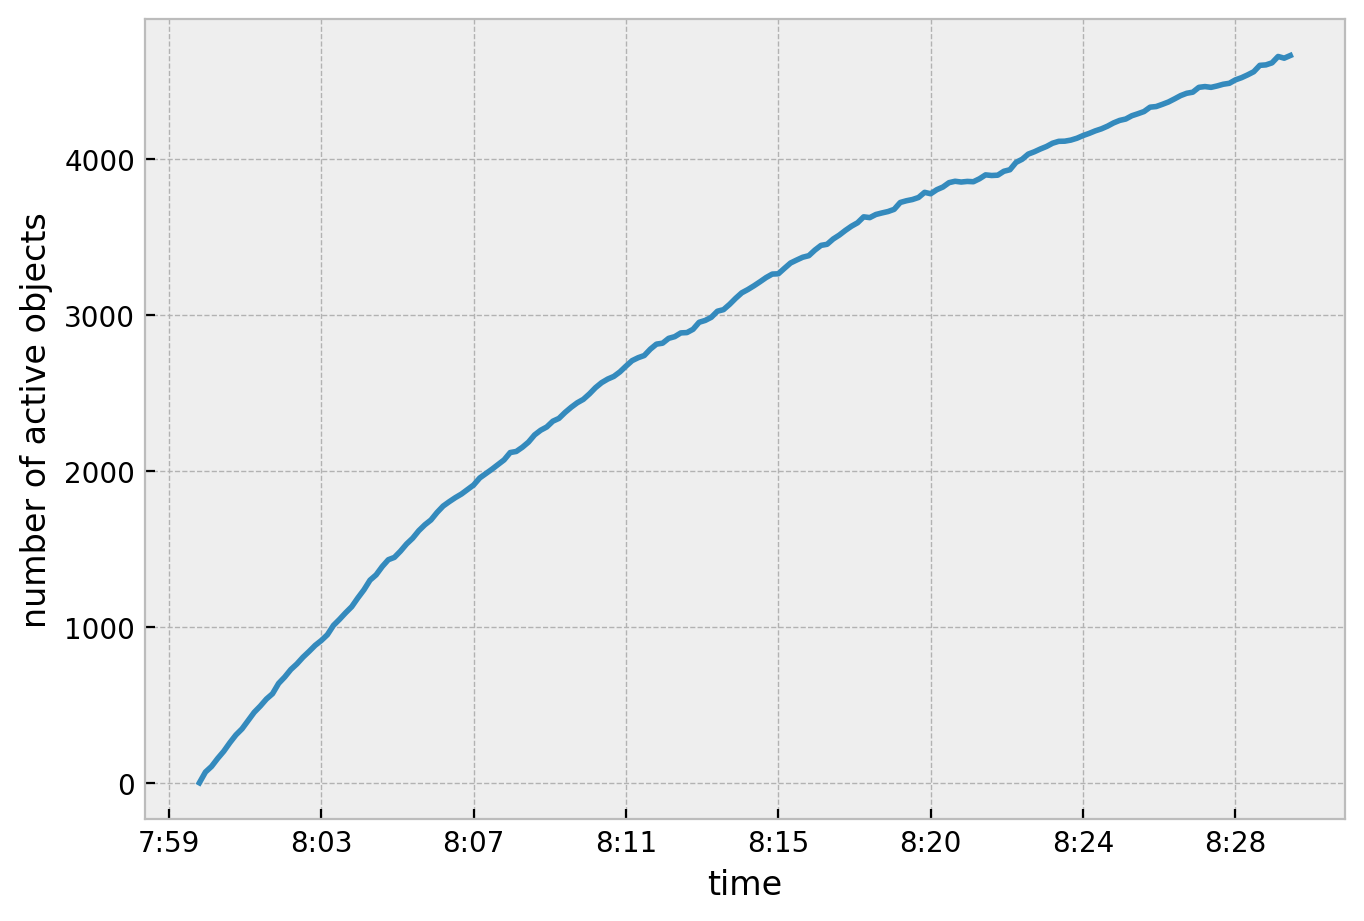

In [13]:
fig = plt.figure(dpi=200)
ax = fig.add_axes([0, 0, 1, 1])

ax.plot(data.groupby(['t']).count()['ID'])

# ax.set_title('Active objects')
ax.set_xlabel('time')
ax.set_ylabel('number of active objects')

labels = []
for tick in ax.get_xticks():
    labels.append(F"{int(tick/3600)}:{int(tick/60 % 60):02}")
ax.set_xticklabels(labels);

##### Min. and max. life time for object

In [14]:
a = data.groupby('ID').count()['t']
Delta = np.diff(data['t'].unique())[0]
print(F"Min. life time: {int((a.min()-1)*Delta/60)} m {int((a.min()-1)*Delta % 60)} s")
print(F"Max. life time: {int((a.max()-1)*Delta/60)} m {int((a.max()-1)*Delta % 60)} s")

Min. life time: 0 m 0 s
Max. life time: 29 m 40 s


##### It looks like some objects only appear in the simulation once:

In [15]:
a[a==a.min()]

ID
commercial_1-3_263           1
commercial_3-1_347           1
commercial_3-1_52            1
commercial_GW1-1_328         1
pedestrian_1-1-pt_4700       1
pedestrian_1-1-pt_4700_tr    1
pedestrian_1-1-pt_485        1
pedestrian_1-1-pt_5676       1
pedestrian_1-2_137           1
pedestrian_1-2_137_tr        1
pedestrian_1-2_3640          1
pedestrian_1-2_3640_tr       1
pedestrian_1-2_5445          1
pedestrian_1-2_5445_tr       1
pedestrian_1-2_5766          1
pedestrian_1-2_5766_tr       1
pedestrian_1-3_2314          1
pedestrian_1-3_2314_tr       1
pedestrian_1-3_848           1
pedestrian_1-3_848_tr        1
pedestrian_1-GW1_11          1
pedestrian_1-GW1_11_tr       1
pedestrian_1-GW1_1728        1
pedestrian_1-GW1_1728_tr     1
pedestrian_1-GW2_1047        1
pedestrian_1-GW2_1047_tr     1
pedestrian_1-GW2_704         1
pedestrian_1-GW2_704_tr      1
pedestrian_1-GW2_884         1
pedestrian_1-GW2_884_tr      1
pedestrian_2-1_1285          1
pedestrian_2-1_1285_tr       1
pedes

##### Number of vehicles, pedestrians and total objects in the simulation

In [16]:
p = len(data['ID'][data['v_type'].isna()].unique())
v = len(data['ID'][data['v_type'].notna()].unique())

print(F"{p+v} objects in the simulations, divided into {p} pedestrians and {v} vehicle of any type")

p+v == len(data['ID'].unique())

8400 objects in the simulations, divided into 4117 pedestrians and 4283 vehicle of any type


True

##### Object demand by time

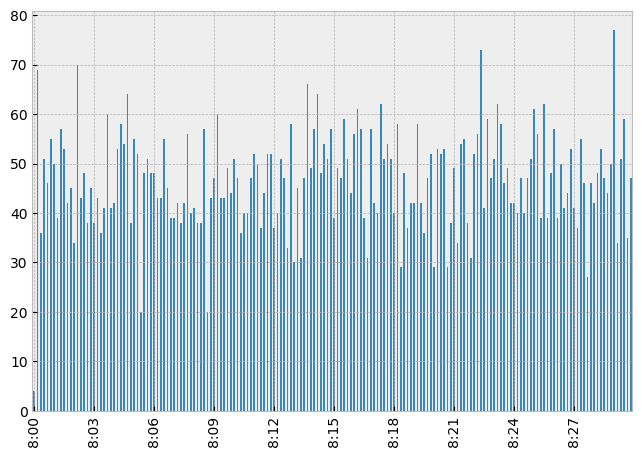

In [29]:
timeSteps = data['t'].unique()
newObjByTime = pd.Series(0, index=timeSteps)

for obj in data['ID'].unique():
    timeFirstAppeared = data[data['ID']==obj]['t'].values[0]
    newObjByTime[timeFirstAppeared]+=1
    print(str(i), end='\r')

fig = plt.figure(dpi=100)
ax = fig.add_axes([0, 0, 1, 1])
newObjByTime.plot.bar();

times = np.linspace(0, len(timeSteps), 10, endpoint=False, dtype=int)
ax.set_xticks(times);
labels = [F"{int(timeSteps[t]/3600)}:{int(timeSteps[t]/60 % 60):02}" for t in times]
ax.set_xticklabels(labels);

In [30]:
data.head()

,t,angle,ID,lane_edge,position,slope,speed,v_type,x,y,z
0,28800.0,74.69,France:Italy.0,152525#0_0,6.60,3.42,0.00,hw_delivery,66.19,2975.45,385.19
1,28800.0,171.94,Italy:France.0,152272_0,16.60,0.84,0.00,hw_trailer,7025.03,6345.15,280.64
2,28800.0,26.74,pedestrian_1-1-pt_7316_tr,152667#1_1,1.70,-1.06,0.00,fastbicycle,5096.54,2373.27,54.36
3,28800.0,26.74,pedestrian_1-1-pt_7316,152667#1,1.70,-1.06,0.00,NaN,5096.54,2373.27,54.36
4,28810.0,83.23,France:Italy.0,152525#0_0,108.82,3.68,18.47,hw_delivery,165.67,2994.41,391.20


In [44]:
##### Let's isolate fast-wheeled vehicles to work on speed

In [45]:
data['v_type'].unique()
motoredObjects = ['hw_delivery', 'hw_trailer', 'bus', 'delivery', 'motorcycle', 'moped', 'taxi', 'uber', 'trailer',
                  'hw_truck', 'hw_coach', 'coach', 'truck', 'hw_motorcycle']
data2 = data[data['v_type'].isin(motoredObjects)]

In [50]:
data2.head()

,t,angle,ID,lane_edge,position,slope,speed,v_type,x,y,z
0,28800.0,74.69,France:Italy.0,152525#0_0,6.60,3.42,0.00,hw_delivery,66.19,2975.45,385.19
1,28800.0,171.94,Italy:France.0,152272_0,16.60,0.84,0.00,hw_trailer,7025.03,6345.15,280.64
4,28810.0,83.23,France:Italy.0,152525#0_0,108.82,3.68,18.47,hw_delivery,165.67,2994.41,391.20
5,28810.0,171.94,Italy:France.0,152272_0,64.18,0.84,8.92,hw_trailer,7031.69,6298.10,281.34
6,28810.0,71.94,bus_M1:France.0,152927_1,23.63,1.31,3.97,bus,1096.59,201.56,54.75


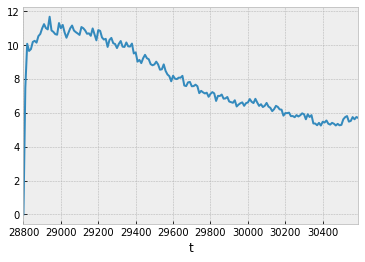

In [52]:
data2.groupby('t').mean()['speed'].plot()